In [1]:
from torchvision import models
from torchvision import transforms
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import requests
import pickle
import time
import math
import os
import base64
import mysql.connector
import networkx as nx

In [110]:
#preprocessing for resnet V1
image_one = Image.open('manga_images/images/0.jpg')
image_one
files = os.listdir('H:/manga_rec/manga_rec_back_end/manga_images/images')
test_image = image.load_img('manga_images/images/0.jpg', target_size = (224, 224))
print(test_image)
images = []
for i in range(len(files)):
    images.append(image.img_to_array(image.load_img('manga_images/images/{}'.format(files[i]), target_size = (224, 224))))
print(images[1].shape)
preProcessedImages = applications.resnet.preprocess_input(np.array(images))
print(preProcessedImages.shape)

<PIL.Image.Image image mode=RGB size=224x224 at 0x1AD11919CC8>
(224, 224, 3)
(5846, 224, 224, 3)


In [112]:
#feature extraction for resnet V1
start_time = time.time()
model = applications.ResNet50(include_top=False, weights='imagenet', pooling='max')
extracted_features_pooled = model.predict(preProcessedImages)
print("Time taken in feature extraction", time.time()-start_time)
print(extracted_features_pooled.shape)
np.save(open('image_saved_data/ResNet50Max_features.npy', 'wb'), extracted_features_pooled)

183/183 [==============================] - 235s 1s/step
Time taken in feature extraction 242.0187726020813
(5846, 2048)


In [109]:
#preprocessing and feature extraction for resnet V2
files = os.listdir('H:/manga_rec/manga_rec_back_end/manga_images/images')
images = []
for i in range(len(files)):
    images.append(image.img_to_array(image.load_img('manga_images/images/{}'.format(files[i]), target_size = (224, 224))))
print(images[1].shape)
preProcessedImagesV2 = applications.resnet_v2.preprocess_input(np.array(images))
print(preProcessedImagesV2.shape)
start_time = time.time()
model = applications.ResNet50V2(include_top=False, weights='imagenet', pooling='avg')
extracted_features_pooled = model.predict(preProcessedImagesV2)
print("Time taken in feature extraction", time.time()-start_time)
print(extracted_features_pooled.shape)
np.save(open('image_saved_data/ResNet50V2Avg_features.npy', 'wb'), extracted_features_pooled)

(224, 224, 3)
(5846, 224, 224, 3)
183/183 [==============================] - 223s 1s/step
Time taken in feature extraction 226.53215098381042
(5846, 2048)


In [ ]:
for i in range(len(extracted_features_raw[0])):
    print(extracted_features_raw[10][i])

In [47]:
img_width, img_height = 224, 224
#img_width, img_height = 42, 62

#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = 'H:/manga_rec/manga_rec_back_end/manga_images'


def new_extract_features():
    files = os.listdir('H:/manga_rec/manga_rec_back_end/manga_images/images')
    images = []
    for i in range(len(files)):
        images.append(image.img_to_array(image.load_img('manga_images/images/{}'.format(files[i]), target_size = (224, 224))))
    images = np.array(images)
    preProcessedImages = applications.resnet.preprocess_input(images)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    extracted_features_raw = model.predict(images)
    print(extracted_features_raw.shape)

nb_train_samples = 5846
epochs = 50
batch_size = 16

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
#     for i in generator.filenames:
#         Itemcodes.append(i[(i.find("/")+1):i.find(".")]) #hopefully this is done in order else maybe
    print()
    extracted_features_raw = model.predict(generator, nb_train_samples // batch_size)
    print(extracted_features_raw.shape)
    print(extracted_features_raw)
    extracted_features = extracted_features_raw.reshape((nb_train_samples, 100352))
    print(extracted_features.shape)
    print(extracted_features)
    
    np.save(open('image_saved_data/ResNet50V2_features.npy', 'wb'), extracted_features)
    #np.save(open('image_saved_data/ResNet_feature_image_ids.npy', 'wb'), np.array(Itemcodes)) #should be able to map back to manga ids

In [48]:
start_time = time.time()
new_extract_features()
print("Time taken in feature extraction", time.time()-start_time)

183/183 [==============================] - 256s 1s/step
(5846, 7, 7, 2048)
Time taken in feature extraction 279.33041048049927


In [ ]:
for i in range(len(extracted_features[0])):
    print(extracted_features[100][i])

In [14]:
#important loading****************************
extracted_features = np.load('image_saved_data/ResNet50Avg_features.npy')
imagesMap = os.listdir('H:/manga_rec/manga_rec_back_end/manga_images/images')
id_title_map = pd.read_csv('H:/manga_rec/manga_rec_back_end/manga_results/manga_ids.csv', header=None).set_index(0).T.to_dict('list')
#image_ids = np.load('image_saved_data/ResNet_feature_image_ids.npy')
#image_ids = list(image_ids)
print(extracted_features[1])

[0.48549715 0.18504243 0.16705292 ... 0.32588768 0.76481986 0.        ]


In [15]:
def get_similar_manga_cnn(features, manga_id, num_results):
    #doc_id = image_ids.index(manga_id)
    image_index = imagesMap.index('{}.jpg'.format(manga_id))
    pairwise_dist = pairwise_distances(features, features[image_index].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input image", "="*20)
    print('Manga id: {}, Manga Title: {}'.format(manga_id, id_title_map[manga_id]))
    display(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}.jpg'.format(manga_id)))
    
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(0,len(indices)):
        print('i: {}, indices[i]: {}, pdists[i]: {}, Manga id: {}, Manga Title: {}'.format(i, indices[i], pdists[i], int(imagesMap[indices[i]][:-4]), id_title_map[int(imagesMap[indices[i]][:-4])]))
        display(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}'.format(imagesMap[indices[i]])))

==================== input image ====================
Manga id: 59, Manga Title: ['JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai']


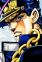


 ==================== Recommended products ====================
i: 0, indices[i]: 3837, pdists[i]: 2.336015541004599e-06, Manga id: 59, Manga Title: ['JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai']


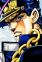

i: 1, indices[i]: 1417, pdists[i]: 2.336015541004599e-06, Manga id: 253, Manga Title: ['JoJo no Kimyou na Bouken Part 6: Stone Ocean']


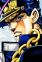

i: 2, indices[i]: 2427, pdists[i]: 31.472318649291992, Manga id: 381, Manga Title: ['JoJo no Kimyou na Bouken Part 3: Stardust Crusaders']


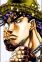

i: 3, indices[i]: 1973, pdists[i]: 31.472318649291992, Manga id: 323, Manga Title: ['JoJo no Kimyou na Bouken Part 2: Sentou Chouryuu']


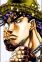

i: 4, indices[i]: 4606, pdists[i]: 32.07590866088867, Manga id: 7261, Manga Title: ['BlazBlue: Variable Heart']


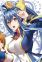

i: 5, indices[i]: 5529, pdists[i]: 32.27310562133789, Manga id: 9266, Manga Title: ['Saikyou no Madoushi. Hiza ni Ya wo Uketeshimatta node Inaka no Eihei ni Naru']


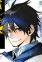

i: 6, indices[i]: 4858, pdists[i]: 32.580013275146484, Manga id: 7732, Manga Title: ['Herscherik: Tensei Ouji no Eiyuutan']


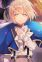

i: 7, indices[i]: 4102, pdists[i]: 32.59177780151367, Manga id: 638, Manga Title: ['Be Blues! Ao ni Nare']


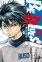

i: 8, indices[i]: 1143, pdists[i]: 32.90299987792969, Manga id: 2226, Manga Title: ['Monster Collection: Majuu Tsukai no Shoujo']


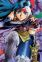

i: 9, indices[i]: 1263, pdists[i]: 33.16667556762695, Manga id: 2354, Manga Title: ['Satou-kun no Juunan Seikatsu']


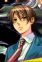

In [16]:
#say you want the manga with the index 20 in the database (haikyuu)
#you can do the following to get its index in the extracted_features array
#print(imagesMap.index('20.jpg'))
#id_title_map[int(imagesMap[757][:-4])]
get_similar_manga_cnn(extracted_features, 59, 10)

In [157]:
extracted_features = np.load('image_saved_data/ResNet152V2Avg_features.npy')

In [158]:
# runs hierarchical clustering ***************************
start_time = time.time()
hierarchical_cluster = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(extracted_features)
print(labels)
print(type(labels))
print("Time taken for hierarchiacal clustering", time.time()-start_time)
np.save(open('image_saved_data/ResNet152V2Avg_100HierarchicalClusters.npy', 'wb'), labels)

[39 31 12 ... 76  5 33]
<class 'numpy.ndarray'>
Time taken for hierarchiacal clustering 23.457002878189087


In [159]:
# kmeans
scaler = StandardScaler()
scaled_features = scaler.fit_transform(extracted_features)

In [160]:
# kmeans
start_time = time.time()
kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_features)
print("Time taken for kmeans fitting", time.time()-start_time)
np.save(open('image_saved_data/ResNet152V2Avg_100KmeansClustersScaled.npy', 'wb'), kmeans.predict(scaled_features))
print("Time taken for kmeans clustering", time.time()-start_time)

Time taken for kmeans fitting 48.674548625946045
Time taken for kmeans clustering 48.703484773635864


In [161]:
# kmeans
start_time = time.time()
kmeans = KMeans(n_clusters=100, random_state=0).fit(extracted_features)
print("Time taken for kmeans fitting", time.time()-start_time)
np.save(open('image_saved_data/ResNet152V2Avg_100KmeansClustersBase.npy', 'wb'), kmeans.predict(extracted_features))
print("Time taken for kmeans clustering", time.time()-start_time)

Time taken for kmeans fitting 48.60539126396179
Time taken for kmeans clustering 48.63431406021118


In [3]:
#important loading****************************
imagesMap = os.listdir('H:/manga_rec/manga_rec_back_end/manga_images/images')
id_title_map = pd.read_csv('H:/manga_rec/manga_rec_back_end/manga_results/manga_ids.csv', header=None).set_index(0).T.to_dict('list')
KmeansClustersScaled_100 = np.load('image_saved_data/ResNet50Avg_100KmeansClustersScaled.npy')
KmeansClustersBase_100 = np.load('image_saved_data/ResNet50Avg_100KmeansClustersBase.npy')
HierarchicalClusters_100 = np.load('image_saved_data/ResNet152V2Avg_100HierarchicalClusters.npy')

In [2]:
def convertRating(ratingTuple):
    mangaId = ratingTuple[2]
    status = ratingTuple[3]
    originalRating = ratingTuple[4]

    if originalRating is not None:
        if originalRating >= 7:
            return mangaId, 5  # 5
        if originalRating >= 5:
            return mangaId, 3  # 3
        else:  # if rating < 5
            return mangaId, 2  # 2
    if status == 'reading' or status == 'completed':
        return mangaId, 4  # 4
    if status == 'plan_to_read':
        return mangaId, 4  # 4
    if status == 'on_hold':
        return mangaId, 3  # 3
    if status == 'dropped':
        return mangaId, 2  # 2
    if status == 'not interested':
        return mangaId, 1
    return mangaId, 4

In [6]:
def manga_index(manga_id): #convert manga_id (from database) to manga_index in the extracted_features array
    return imagesMap.index('{}.jpg'.format(manga_id))

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst
def concat_images(images):
    rows = math.ceil(len(images)/20)
    for row in range(rows):
        dst = Image.new('RGB', (min(images[0].width*20, images[0].width*(len(images) - (row*20))), images[0].height))
        #print(min(images[0].width*20, images[0].width*(len(images) - (row*20))))
#         for i in range((row*20), min((row*20)+20, len(images))):
#             print(i)
#             display(images[i])
        for i in range(min(20, (len(images)-(row*20)))):
            dst.paste(images[i+(row*20)], (images[0].width*i, 0))
        display(dst)

def display_all_clusters(clusters, numClusters):
    for i in range(numClusters):
        print("="*20, "cluster index: {}".format(i), "="*20)
        display_manga_images_from_Cluster(i, clusters)
def display_manga_titles_from_Cluster(cluster, clusters):
    for i in range(len(clusters)):
        if clusters[i] == cluster:
            print('Manga id: {}, Manga Title: {}'.format(imagesMap[i][:-4], id_title_map[int(imagesMap[i][:-4])]))
def display_manga_from_Cluster(cluster, clusters):
    for i in range(len(clusters)):
        if clusters[i] == cluster:
            display(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}'.format(imagesMap[i])))
            print('Manga id: {}, Manga Title: {}'.format(imagesMap[i][:-4], id_title_map[int(imagesMap[i][:-4])]))
def display_manga_images_from_Cluster(cluster, clusters):
    img_ids = []
    images = []
    for i in range(len(clusters)):
        if clusters[i] == cluster:
            img_ids.append(i)
    for i in img_ids:
        images.append(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}'.format(imagesMap[i])))
        #display(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}'.format(imagesMap[i])))
    concat_images(images)
    
def display_manga_from_highestRatedClusters(clusterScores, clusters):
    print('clusterScores after', clusterScores)
    highestClusterScore = max(clusterScores)
    print('highestClusterScore', highestClusterScore)
    highestRatedClusters = [i for i, x in enumerate(clusterScores) if x == highestClusterScore]
    print(highestRatedClusters)
    #display_manga_from_highestRatedClusters(highestRatedClusters, clusters)
    for cluster in highestRatedClusters:
        print("="*20, "cluster index: {}, cluster score: {}".format(cluster, clusterScores[cluster]), "="*20)
        #print all images in this cluster
        display_manga_titles_from_Cluster(cluster, clusters)
        display_manga_images_from_Cluster(cluster, clusters)

def recommendFromClusters(userId, clusters, numClusters):
    dataBase = mysql.connector.connect(
        host="washington.uww.edu",
        user="stremmeltr18",
        passwd=base64.b64decode(b'dHM1NjEy').decode("utf-8"),
        database="manga_rec"
    )
    myCursor = dataBase.cursor()
    myCursor.execute("select * from ratings where userId = %s;", [userId])
    ratings = [x for x in myCursor]
    convertedRatings = [convertRating(x) for x in ratings]
    
    clusterScores = [0] * numClusters
    for manga in convertedRatings:
#         print('manga', manga_index(manga[0]))
        clusterScores[clusters[manga_index(manga[0])]] += (manga[1] - 2)#1 # use to include ratings -> (manga[1] - 2)
        #does -2 so that 'negative' ratings decrease the clusterScore for that manga
    orderedClusters = np.argsort(clusterScores)[::-1]
    print('orderedClusters', orderedClusters)
    display_manga_from_highestRatedClusters(clusterScores, clusters)

orderedClusters [15  1  4 14 50 99 40 39 54 23 74 78 17 72  8 10 94  6 91 55 61 18 26  3
  2 38 31 37  5 41 42 36 35 34 33 32 11 28 30 29 12 27 25 24 22 44 21 20
 19  7 16  9 13 43 49 45 73 76 77 79 80 81 82 83 84 85 86 87 88 89 90 92
 93 95 96 97 75 71 46 70 47 48 98 51 52 53 56 57 58 59 60 62 63 64 65 66
 67 68 69  0]
clusterScores after [0, 7, 0, 0, 6, 0, 2, 0, 3, 0, 3, 0, 0, 0, 5, 8, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 3]
highestClusterScore 8
[15]
==================== cluster index: 15, cluster score: 8 ====================
Manga id: 101, Manga Title: ['Holyland']
Manga id: 1057, Manga Title: ['RG Veda']
Manga id: 1071, Manga Title: ['Saiyuuki Ibun']
Manga id: 1120, Manga Title: ['Hyouge Mono']
Manga id: 1130, Manga Title: ['Shuujin Riku']
Manga id: 1166, Manga Title: ['B

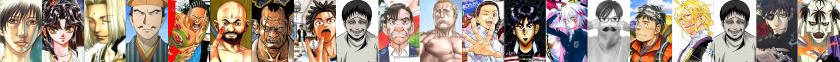

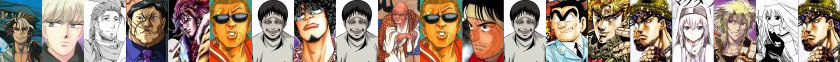

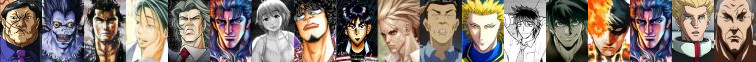

In [32]:
recommendFromClusters(17441, HierarchicalClusters_100, 100)

In [6]:
unique, counts = np.unique(KmeansClustersBase_100, return_counts=True)
print(np.asarray((unique, counts)).T)
print(max(counts))
print(min(counts))
print(np.std(counts))


[[  0  36]
 [  1  67]
 [  2  41]
 [  3  95]
 [  4  26]
 [  5  44]
 [  6 100]
 [  7  42]
 [  8  74]
 [  9  56]
 [ 10  45]
 [ 11   8]
 [ 12  92]
 [ 13  38]
 [ 14  64]
 [ 15  52]
 [ 16  76]
 [ 17  27]
 [ 18  31]
 [ 19  54]
 [ 20  79]
 [ 21  56]
 [ 22  88]
 [ 23  82]
 [ 24  38]
 [ 25  70]
 [ 26  65]
 [ 27  64]
 [ 28  69]
 [ 29  54]
 [ 30  52]
 [ 31  58]
 [ 32  46]
 [ 33  59]
 [ 34  54]
 [ 35  78]
 [ 36  76]
 [ 37  59]
 [ 38  63]
 [ 39  61]
 [ 40  44]
 [ 41  60]
 [ 42  96]
 [ 43  79]
 [ 44  81]
 [ 45  13]
 [ 46  41]
 [ 47  14]
 [ 48  80]
 [ 49  68]
 [ 50  42]
 [ 51  88]
 [ 52  62]
 [ 53  82]
 [ 54  53]
 [ 55  54]
 [ 56  52]
 [ 57  72]
 [ 58  60]
 [ 59  61]
 [ 60  55]
 [ 61  29]
 [ 62  70]
 [ 63  49]
 [ 64  80]
 [ 65  62]
 [ 66  57]
 [ 67  74]
 [ 68  29]
 [ 69  25]
 [ 70  69]
 [ 71  65]
 [ 72  46]
 [ 73 102]
 [ 74  39]
 [ 75 103]
 [ 76  64]
 [ 77  47]
 [ 78  61]
 [ 79  78]
 [ 80  60]
 [ 81  46]
 [ 82  57]
 [ 83  43]
 [ 84  67]
 [ 85  61]
 [ 86  12]
 [ 87  52]
 [ 88  48]
 [ 89  70]
 [ 90  64]

In [ ]:
display_manga_images_from_Cluster(0, HierarchialClusters_100)
display_manga_titles_from_Cluster(0, HierarchialClusters_100)

In [98]:
HierarchialClusters_100[manga_index(7815)]

10

In [ ]:
display_all_clusters(KmeansClustersBase_100, 100)

In [4]:
def CreateGraph(features, title):
    #note the nodes are the feature indicies not manga_ids
    graph = nx.Graph()
    for i in range(len(features)):
        for j in range(len(features)):
            if i != j:
                #np.linalg.norm(features[i]-features[j] is the euclidean distance
                graph.add_edge(i, j, weight=np.linalg.norm(features[i]-features[j]))
    nx.write_weighted_edgelist(graph, 'image_saved_data/{}_graph'.format(title))

In [10]:
start_time = time.time()
CreateGraph(np.load('image_saved_data/ResNet50V2Max_features.npy'), 'ResNet50V2Max')
print("Time taken to create graph", time.time()-start_time)

Time taken to create graph 314.46859431266785


In [23]:
def CreateMatrix(features_title):
    features = np.load('image_saved_data/{}_features.npy'.format(features_title))
    print(features.shape)
    #matrix = np.zeros((5846, 5846))
    matrix = pairwise_distances(features)
    print(matrix.shape)
    print(matrix)
    np.save('image_saved_data/{}_distanceMatrix'.format(features_title), matrix)

def recommendFromMatrixV2(userId, k, matrix_title):
    dataBase = mysql.connector.connect(
        host="washington.uww.edu",
        user="stremmeltr18",
        passwd=base64.b64decode(b'dHM1NjEy').decode("utf-8"),
        database="manga_rec"
    )
    myCursor = dataBase.cursor()
    myCursor.execute("select * from ratings where userId = %s;", [userId])
    ratings = [x for x in myCursor]
    convertedRatings = [convertRating(x) for x in ratings]
    print(convertedRatings)
    
    startTime = time.time()
    distanceMatrix = np.load('image_saved_data/{}_distanceMatrix.npy'.format(matrix_title))
    print('loading took', time.time() - startTime)
    
    mangaScores = np.zeros((5846))
    inverseRating = [5, 4, 3, 2, 1]
    print(mangaScores)
    for manga in convertedRatings:
        #note manga[0] is the manga_id in database
        print('mangaId: {}, mangaIndex: {}, mangaTitle: {}'.format(manga[0], get_manga_index(manga[0]), get_manga_title(manga[0])))
        orderedIndices = np.argsort(distanceMatrix[get_manga_index(manga[0])])
        for manga_index in range(len(mangaScores)):
            mangaScores[manga_index] += distanceMatrix[get_manga_index(manga[0])][manga_index] * inverseRating[manga[1]-1]
    topManga = (mangaScores).argsort()[:k*2]
    images = []
    for index in topManga:
        print('mangaId: {}, mangaIndex: {}, score: {}, mangaTitle: {}'.format(get_manga_id(index), index, mangaScores[index], get_manga_title(get_manga_id(index))))
        images.append(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}.jpg'.format(get_manga_id(index))))
    concat_images(images)
    print('total time:', time.time()-startTime)
    
def recommendFromMatrix(userId, k, matrix_title):
    dataBase = mysql.connector.connect(
        host="washington.uww.edu",
        user="stremmeltr18",
        passwd=base64.b64decode(b'dHM1NjEy').decode("utf-8"),
        database="manga_rec"
    )
    myCursor = dataBase.cursor()
    myCursor.execute("select * from ratings where userId = %s;", [userId])
    ratings = [x for x in myCursor]
    convertedRatings = [convertRating(x) for x in ratings]
    print(convertedRatings)
    
    startTime = time.time()
    distanceMatrix = np.load('image_saved_data/{}_distanceMatrix.npy'.format(matrix_title))
    print('loading took', time.time() - startTime)
    
    mangaScores = np.zeros((5846))
    print(mangaScores)
    for manga in convertedRatings:
        #note manga[0] is the manga_id in database
        print('mangaId: {}, mangaIndex: {}, mangaTitle: {}'.format(manga[0], get_manga_index(manga[0]), get_manga_title(manga[0])))
        orderedIndices = np.argsort(distanceMatrix[get_manga_index(manga[0])])
        images = []
        for index in orderedIndices:
            if len(images) >= k:
                break
            #check filters here
            mangaScores[index] += (manga[1] - 2)
            images.append(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}.jpg'.format(get_manga_id(index))))
        concat_images(images)
    topManga = (-mangaScores).argsort()[:k*2]
    images = []
    for index in topManga:
        print('mangaId: {}, mangaIndex: {}, score: {}, mangaTitle: {}'.format(get_manga_id(index), index, mangaScores[index], get_manga_title(get_manga_id(index))))
        images.append(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}.jpg'.format(get_manga_id(index))))
    concat_images(images)
    print('total time:', time.time()-startTime)

[(312, 5), (0, 5), (769, 5), (34, 4), (2049, 2), (132, 5), (225, 4), (20, 5), (1311, 5), (101, 5), (105, 5), (139, 5), (19, 4), (9793, 3), (221, 5), (937, 4), (1110, 5), (1236, 4), (4, 4), (1619, 5), (444, 4), (2196, 5), (211, 3), (62, 5), (2, 5), (506, 5), (2033, 5), (60, 5), (567, 4), (2113, 2), (9, 5), (3662, 4)]
loading took 0.05183911323547363
[0. 0. 0. ... 0. 0. 0.]
mangaId: 312, mangaIndex: 1890, mangaTitle: ['Akumetsu']
mangaId: 0, mangaIndex: 0, mangaTitle: ['Berserk']
mangaId: 769, mangaIndex: 4836, mangaTitle: ['Bonnouji']
mangaId: 34, mangaIndex: 2107, mangaTitle: ['Chainsaw Man']
mangaId: 2049, mangaIndex: 987, mangaTitle: ['Code:Breaker']
mangaId: 132, mangaIndex: 314, mangaTitle: ['Dragon Ball']
mangaId: 225, mangaIndex: 1165, mangaTitle: ["Eden: It's an Endless World!"]
mangaId: 20, mangaIndex: 944, mangaTitle: ['Haikyuu!!']
mangaId: 1311, mangaIndex: 306, mangaTitle: ['Handa-kun']
mangaId: 101, mangaIndex: 14, mangaTitle: ['Holyland']
mangaId: 105, mangaIndex: 52, mang

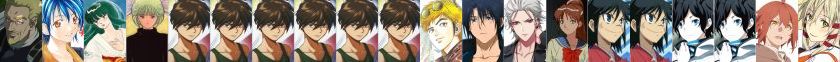

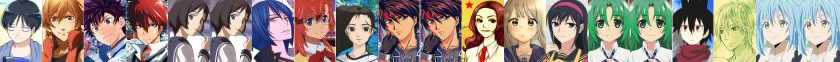

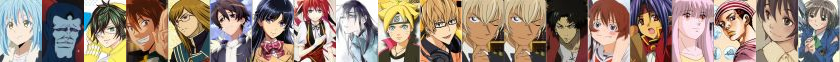

total time: 6.133244037628174


In [24]:
recommendFromMatrixV2(17441, 30, 'ResNet152V2Avg')

In [9]:
imagesMap = os.listdir('H:/manga_rec/manga_rec_back_end/manga_images/images')
id_title_map = pd.read_csv('H:/manga_rec/manga_rec_back_end/manga_results/manga_ids.csv', header=None).set_index(0).T.to_dict('list')
def get_manga_index(manga_id): #convert manga_id (from database) to manga_index in the extracted_features array
    return imagesMap.index('{}.jpg'.format(manga_id))
def get_manga_id(manga_index): #convert manga_index (node names in the graph) to manga_id (from database)
    return int(imagesMap[manga_index][:-4])
def get_manga_title(manga_id):
    return id_title_map[manga_id]
def concat_images(images):
    rows = math.ceil(len(images)/20)
    for row in range(rows):
        dst = Image.new('RGB', (min(images[0].width*20, images[0].width*(len(images) - (row*20))), images[0].height))
        for i in range(min(20, (len(images)-(row*20)))):
            dst.paste(images[i+(row*20)], (images[0].width*i, 0))
        display(dst)

def recommendFromGraph(userId, graphTitle):
    dataBase = mysql.connector.connect(
        host="washington.uww.edu",
        user="stremmeltr18",
        passwd=base64.b64decode(b'dHM1NjEy').decode("utf-8"),
        database="manga_rec"
    )
    myCursor = dataBase.cursor()
    myCursor.execute("select * from ratings where userId = %s;", [userId])
    ratings = [x for x in myCursor]
    convertedRatings = [convertRating(x) for x in ratings]
    print(convertedRatings)
    startTime = time.time()
    graph = nx.read_weighted_edgelist('image_saved_data/{}'.format(graphTitle))
    print('reaing graph took:', time.time()-startTime)
    startTime = time.time()
    graph.add_node('user')
    for manga in convertedRatings:
        #note manga[0] is the manga_id in database
        print('manga', get_manga_index(manga[0]))
        if manga[1] > 2: #only make edges to that manga if they liked it, intrested, or neutural
            graph.add_edge('user', get_manga_index(manga[0]), weight=1)
    print('adding user to graph took:', time.time()-startTime)
    startTime = time.time()
    distances = nx.single_source_dijkstra_path_length(graph, 'user')
    print('getting distances took:', time.time()-startTime)
    distances_sorted = sorted(distances.items(), key=lambda item: item[1])
    images = []
    for i in range(0, 10):
        print(get_manga_title(get_manga_id(distances_sorted[i][0])))
        images.append(images.append(Image.open('H:/manga_rec/manga_rec_back_end/manga_images/images/{}'.format(get_manga_id(distances_sorted[i][0])))))
    concat_images(images)

In [24]:
recommendFromGraph(17441, 'ResNet152Avg_graph')

[(312, 5), (0, 5), (769, 5), (2049, 2), (132, 5), (225, 4), (20, 5), (1311, 5), (101, 5), (105, 5), (139, 5), (19, 4), (9793, 3), (221, 5), (937, 4), (1110, 5), (1236, 4), (4, 4), (1619, 5), (444, 4), (2196, 5), (211, 3), (62, 5), (2, 5), (506, 5), (2033, 5), (60, 5), (2113, 2), (9, 5), (3662, 4), (312, 5), (0, 5), (769, 5), (2049, 2), (132, 5), (225, 4), (20, 5), (1311, 5), (101, 5), (105, 5), (139, 5), (19, 4), (9793, 3), (221, 5), (937, 4), (1110, 5), (1236, 4), (4, 4), (1619, 5), (444, 4), (2196, 5), (211, 3), (62, 5), (2, 5), (506, 5), (2033, 5), (60, 5), (567, 4), (2113, 2), (9, 5), (3662, 4), (1997, 4), (2151, 4)]
reaing graph took: 64.6176826953888
manga 1890
manga 0
manga 4836
manga 987
manga 314
manga 1165
manga 944
manga 306
manga 14
manga 52
manga 378
manga 856
manga 5765
manga 1128
manga 5573
manga 115
manga 236
manga 2565
manga 606
manga 2886
manga 1121
manga 1040
manga 4001
manga 943
manga 3309
manga 972
manga 3895
manga 1044
manga 5405
manga 2319
manga 1890
manga 0
mang

TypeError: list indices must be integers or slices, not str

In [37]:
print(np.zeros(shape=(9999, 2)))

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
